In [1]:
import pandas as pd

def set_pandas_display_options(count):
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = count
    display.max_rows = count
    display.max_colwidth = count
    display.width = count

# Increase this value to display more info from pandas
set_pandas_display_options(500)

In [2]:
df = pd.read_csv('data.csv')

In [3]:
# Add article category from file name
# The category is between the first "\" to the first "-"
# For example: Articles\music-news_world_Article-b1685ab6f1d8471026_1641315437.html -> \music- -> music is the category
# Some categories end with _Arctile, remove that if needed
categories = [name[name.find('\\') + 1:name.find('-')].replace('_Article', '') for name in df.file_name]
df['categories'] = pd.Series(categories, dtype='category')

In [4]:
# Drop textarea_count - it's always zero
df.drop(columns=['textarea_count'], inplace=True)

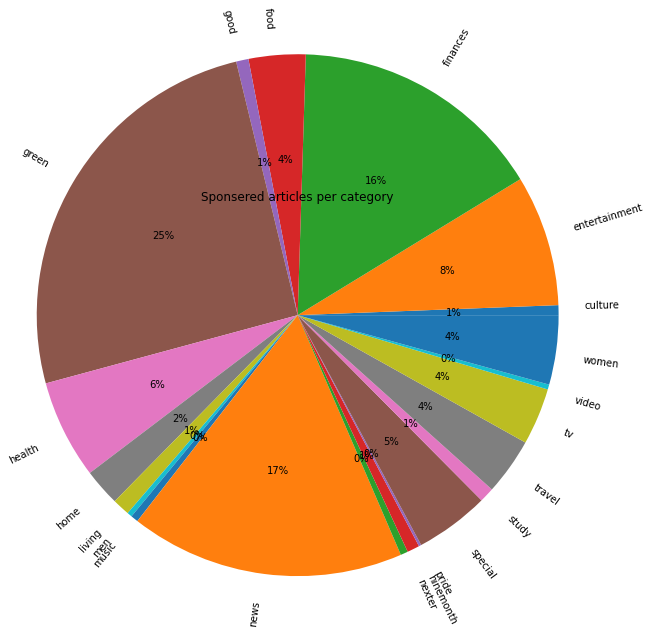

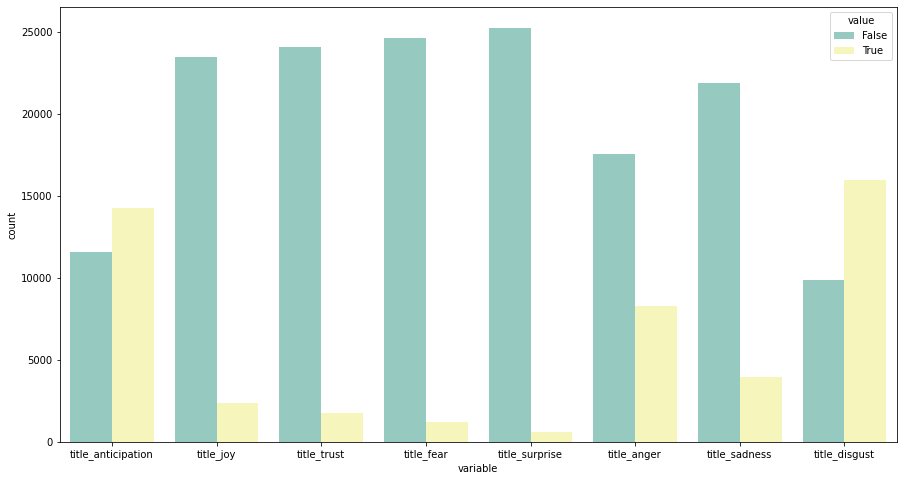

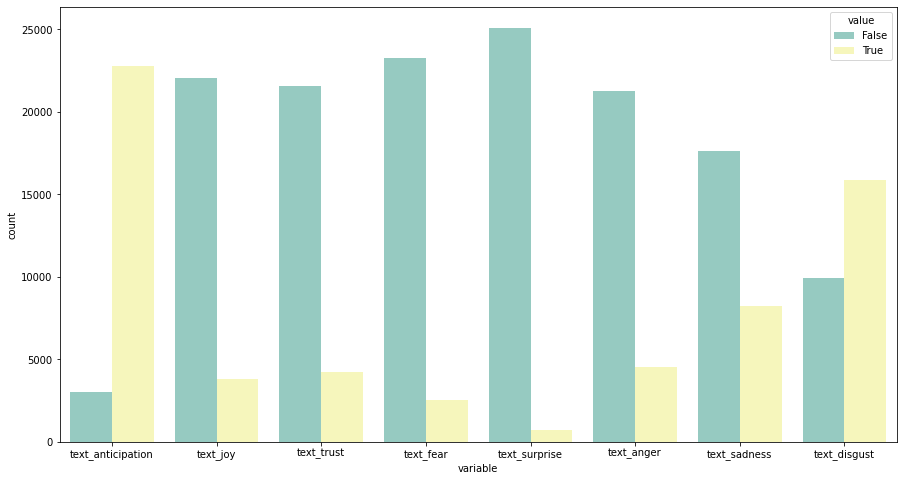

In [5]:
from collections import Counter
data = Counter(df[df.is_sponsered == True].categories)

import matplotlib.pyplot as plt
plt.pie(data.values() ,labels=data.keys(), autopct='%1.0f%%', rotatelabels=True, radius=3)
plt.title('Sponsered articles per category')
plt.show()

emotion_names = ["anticipation", "joy", "trust", "fear", "surprise", "anger", "sadness", "disgust"]
title_emotions = [f'title_{name}' for name in emotion_names]
text_emotions = [f'text_{name}' for name in emotion_names]

import seaborn as sns

plt.figure(figsize=(15,8))
sns.countplot(x="variable", hue="value", data=pd.melt(df[title_emotions]), palette="Set3")
plt.show()

plt.figure(figsize=(15,8))
sns.countplot(x="variable", hue="value", data=pd.melt(df[text_emotions]), palette="Set3")
plt.show()

In [6]:
correlation = df.corr()
correlation.style.background_gradient(cmap='coolwarm')

,is_sponsered,bold_count,is_advertisement,links_count,input_count,media_count,title_length,text_length,mutual_title_text_keywords_count,title_anticipation,title_joy,title_trust,title_fear,title_surprise,title_anger,title_sadness,title_disgust,text_anticipation,text_joy,text_trust,text_fear,text_surprise,text_anger,text_sadness,text_disgust
is_sponsered,1.000000,0.030778,0.118966,0.024641,0.030588,0.040039,-0.073073,-0.044021,-0.063163,0.081684,0.093137,0.050564,-0.025444,0.017044,-0.063342,-0.042668,-0.107928,-0.060017,0.115454,0.185821,-0.040982,-0.009569,-0.058957,-0.066009,-0.133599
bold_count,0.030778,1.000000,0.011110,0.767536,0.074767,0.786487,-0.178947,0.263958,-0.031521,0.139011,0.093852,0.082044,-0.076822,0.042474,-0.092195,-0.020995,-0.152531,0.085592,0.098267,0.004709,-0.084527,0.024198,-0.033118,-0.061853,-0.070167
is_advertisement,0.118966,0.011110,1.000000,0.011978,0.000981,0.010660,-0.013938,0.008947,0.001671,0.021726,0.025904,0.031485,-0.005373,-0.003662,-0.013079,-0.010275,-0.020743,-0.001193,0.012662,0.019711,-0.007988,-0.004107,-0.011149,-0.016458,-0.030465
links_count,0.024641,0.767536,0.011978,1.000000,0.270752,0.900548,-0.196230,0.012803,-0.034358,0.108846,0.074530,0.071658,-0.091127,0.049287,-0.060518,0.004396,-0.122284,0.057870,0.077020,-0.020270,-0.103044,0.029833,-0.028313,-0.046949,-0.049409
input_count,0.030588,0.074767,0.000981,0.270752,1.000000,0.147328,0.109581,-0.082805,-0.068554,-0.058974,-0.005795,0.000621,0.089888,0.003898,0.031628,0.062008,0.035009,-0.086004,-0.016848,0.068330,0.123194,-0.017689,0.020348,0.121203,-0.036190
media_count,0.040039,0.786487,0.010660,0.900548,0.147328,1.000000,-0.226550,0.181990,-0.020152,0.131643,0.111607,0.078306,-0.089956,0.040867,-0.079550,-0.010654,-0.153496,0.100603,0.130529,-0.007743,-0.095499,0.033671,-0.014797,-0.038744,-0.064082
title_length,-0.073073,-0.178947,-0.013938,-0.196230,0.109581,-0.226550,1.000000,0.058093,0.178837,-0.106596,-0.103097,-0.048465,0.135396,-0.085836,0.198446,0.233982,0.230578,-0.011263,-0.161632,-0.156502,0.117381,-0.015548,0.140153,0.206294,0.224638
text_length,-0.044021,0.263958,0.008947,0.012803,-0.082805,0.181990,0.058093,1.000000,-0.006584,0.034465,0.022190,0.004121,0.027247,0.021188,-0.004900,0.006817,0.002895,0.114994,0.020101,-0.069600,0.028289,0.016556,0.057996,0.032465,0.087007
mutual_title_text_keywords_count,-0.063163,-0.031521,0.001671,-0.034358,-0.068554,-0.020152,0.178837,-0.006584,1.000000,0.014384,-0.042308,-0.031683,-0.001941,-0.028056,-0.041347,-0.031015,-0.000330,0.136532,-0.018196,-0.115674,-0.006044,-0.026275,0.022250,0.010216,0.077682
title_anticipation,0.081684,0.139011,0.021726,0.108846,-0.058974,0.131643,-0.106596,0.034465,0.014384,1.000000,0.262942,0.240127,-0.125247,0.049446,-0.477054,-0.204735,-0.506019,0.207052,0.191735,0.143695,-0.140406,0.008367,-0.210478,-0.211217,-0.257466


In [7]:
# One-hot-encode the categories using LabelBinarizer
# Copied from https://stackoverflow.com/questions/58101126/using-scikit-learn-onehotencoder-with-a-pandas-dataframe
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
encoder.fit(df['categories'])
transformed = encoder.transform(df['categories'])
ohe_df = pd.DataFrame(transformed, columns=df.categories.unique())
# Also drop the categories column because it is non-numeric
categories = df.categories
df = pd.concat([df, ohe_df], axis=1).drop(['categories'], axis=1)

In [8]:
# Drop the file_name column because it is non-numeric
file_names = df.file_name
df.drop(columns=['file_name'], inplace=True)

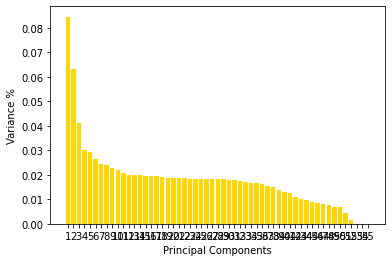

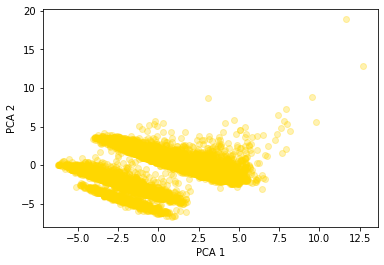

In [9]:
# Dimensionality Reduction with PCA - copied from https://andrewmourcos.github.io/blog/2019/06/06/PCA.html
# First normalize the data
from sklearn.preprocessing import StandardScaler
std_data = StandardScaler().fit_transform(df)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA()
pca_data = pca.fit_transform(std_data)
pca_df = pd.DataFrame(pca_data)

# Plotting the variances for each PC
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='gold')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)
plt.show()

plt.scatter(pca_df[0], pca_df[1], alpha=.3, color='gold')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

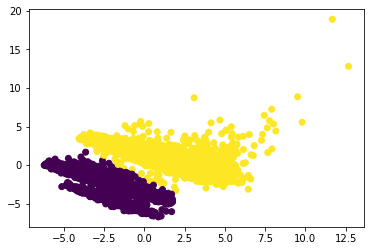

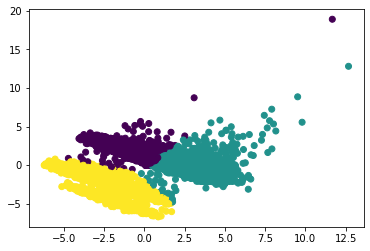

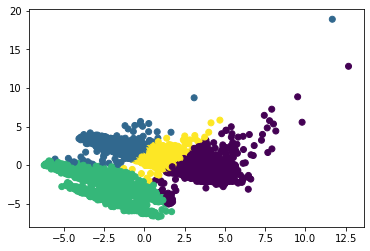

In [10]:
# Chose the correct K for KMeans - copied from https://andrewmourcos.github.io/blog/2019/06/06/PCA.html
from sklearn.cluster import KMeans

for i in range(2, 5):
    km = KMeans(n_clusters=i)
    km = km.fit(pca_df.iloc[:,:2])
    plt.scatter(pca_df[0], pca_df[1], c=km.labels_)
    plt.show()

In [11]:
km = KMeans(n_clusters=2)
km = km.fit(pca_df.iloc[:,:2])
labels = km.labels_

In [12]:
df['label'] = labels
# Get the file names and categories back
df['categories'] = categories
df['file_name'] = file_names

In [13]:
def print_column_count(label, column):
    print(f'{column} count')
    print(label[column].value_counts())
    print()

def print_label_info(label_num):
    print(f'Info for label #{label_num}')
    label = df[df.label == label_num]
    print(f'Items count: {df.file_name.count()}')
    
    print_column_count(label, 'is_sponsered')
    print_column_count(label, 'is_advertisement')
    print_column_count(label, 'categories')
    
    print('File names sample:')
    print(label.sample(n=10).file_name)
    return label

In [14]:
df.label.value_counts()

1    20114
0     5722
Name: label, dtype: int64

In [15]:
label_0 = print_label_info(0)

Info for label #0
Items count: 25836
is_sponsered count
False    5612
True      110
Name: is_sponsered, dtype: int64

is_advertisement count
False    5722
Name: is_advertisement, dtype: int64

categories count
news             4566
tvbee            1156
24tv                0
Sports              0
video               0
tv                  0
travel              0
study               0
spirituality        0
special             0
pzm                 0
pride               0
opinions            0
ninemonth           0
nexter              0
music               0
men                 0
maariv              0
living              0
home                0
hix                 0
health              0
green               0
good                0
food                0
finances            0
entertainment       0
culture             0
cannabis            0
women               0
Name: categories, dtype: int64

File names sample:
17291     Articles\news-podcast_n12_one_a_day_Article-b0e08140a705b71026_164131

In [16]:
label_1 = print_label_info(1)

Info for label #1
Items count: 25836
is_sponsered count
False    19571
True       543
Name: is_sponsered, dtype: int64

is_advertisement count
False    20099
True        15
Name: is_advertisement, dtype: int64

categories count
entertainment    2857
men              2007
travel           1971
music            1865
tv               1780
finances         1557
hix              1208
women            1205
culture          1089
food              902
health            826
nexter            540
pride             394
cannabis          342
home              287
green             270
living            244
good              224
Sports            172
pzm               132
ninemonth          75
spirituality       53
special            35
news               31
video              19
study              14
opinions            7
24tv                4
tvbee               3
maariv              1
Name: categories, dtype: int64

File names sample:
5807                 Articles\finances-real-estate_Article-de

Label 0: Count: 5722, Percentage: 22.15%
Label 1: Count: 20114, Percentage: 77.85%


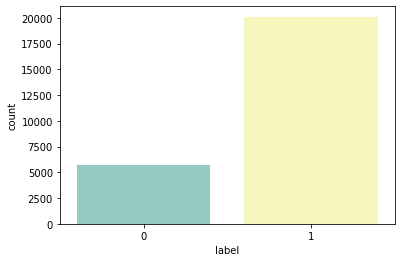

In [17]:
print(f'Label 0: Count: {label_0.file_name.count()}, Percentage: {100 * label_0.file_name.count() / df.file_name.count():.2f}%')
print(f'Label 1: Count: {label_1.file_name.count()}, Percentage: {100 * label_1.file_name.count() / df.file_name.count():.2f}%')
sns.countplot(x='label', data=df, palette="Set3")
plt.show()